# Stroke Prediction

#### Importo le librerie

In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns

#### Apriamo la sessione di Spark e carichiamo il dataset

In [2]:
spark = SparkSession.builder.appName('project').getOrCreate()
df = spark.read.csv("healthcare-dataset-stroke-data.csv", inferSchema=True, header=True)

#### Prima visualizzazione del dataset

In [3]:
df.show(7)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

#### Visualizzo anche attraverso Pandas, che ci da una visualizzazione più accattivante del dataset

In [4]:
pd_df = df.toPandas()
pd_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


#### Vediamo anche la forma del dataset, ossia da quante righe e colonne è composto:

In [5]:
pd_df.shape

(5110, 12)

#### Visualizziamo altre informazioni aggiuntive, come il tipo delle variabili:

In [6]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



#### Un piccolo summary di alcune variabili, principalmente quelle numeriche, in quanto andiamo a vedere media, deviazione standard e minimo e massimo. Lo faccio sia per stroke = 0, sia per stroke = 1.

In [7]:
df.filter(df['stroke'] == '0').describe(['age', 'avg_glucose_level', 'bmi']).show()

+-------+------------------+------------------+------------------+
|summary|               age| avg_glucose_level|               bmi|
+-------+------------------+------------------+------------------+
|  count|              4861|              4861|              4861|
|   mean|41.971544949598865|104.79551326887444|28.823063829787245|
| stddev| 22.29194038460048| 43.84606850027663|  7.90828707392947|
|    min|              0.08|             55.12|              10.3|
|    max|              82.0|            267.76|               N/A|
+-------+------------------+------------------+------------------+



In [8]:
df.filter(df['stroke'] == '1').describe(['age', 'avg_glucose_level', 'bmi']).show()

+-------+------------------+------------------+-----------------+
|summary|               age| avg_glucose_level|              bmi|
+-------+------------------+------------------+-----------------+
|  count|               249|               249|              249|
|   mean| 67.72819277108434|132.54473895582322|30.47129186602871|
| stddev|12.727419360404237|  61.9210555806822|6.329451820046447|
|    min|              1.32|             56.11|             16.9|
|    max|              82.0|            271.74|              N/A|
+-------+------------------+------------------+-----------------+



#### Noto subito che la colonna 'bmi' ha dei valori NA, che andrò a gestire successivamente

#### Proseguo con ulteriori esplorazioni del dataset

##### Persone di genere femminile che hanno avuto un infarto

In [9]:
df.filter(df.gender == "Female").where(df.stroke == '1').show(10, truncate=False)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|id   |gender|age |hypertension|heart_disease|ever_married|work_type    |Residence_type|avg_glucose_level|bmi |smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|51676|Female|61.0|0           |0            |Yes         |Self-employed|Rural         |202.21           |N/A |never smoked  |1     |
|60182|Female|49.0|0           |0            |Yes         |Private      |Urban         |171.23           |34.4|smokes        |1     |
|1665 |Female|79.0|1           |0            |Yes         |Self-employed|Rural         |174.12           |24  |never smoked  |1     |
|10434|Female|69.0|0           |0            |No          |Private      |Urban         |94.39            |22.8|never smoked  |1     |
|27419|Female|59.0|0           |0            |Yes         |Pri

##### Dato che è la variabile di risposta (target), vedo quale è la quantità di persone che hanno avuto l'ictus e quante no

In [10]:
df.groupby("stroke").count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



#### Ci sono 249 persone che hanno avuto un ictus e 4861 che non lo hanno avuto

## DATA CLEANING

### NA, Nan e NULL

#### Elimino la colonna 'id' perché non è utile ai fini dell'analisi e poi rimando a grafico

In [11]:
new_df = df.drop('id')
new_df.show(truncate=False)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender|age |hypertension|heart_disease|ever_married|work_type    |Residence_type|avg_glucose_level|bmi |smoking_status |stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|Male  |67.0|0           |1            |Yes         |Private      |Urban         |228.69           |36.6|formerly smoked|1     |
|Female|61.0|0           |0            |Yes         |Self-employed|Rural         |202.21           |N/A |never smoked   |1     |
|Male  |80.0|0           |1            |Yes         |Private      |Rural         |105.92           |32.5|never smoked   |1     |
|Female|49.0|0           |0            |Yes         |Private      |Urban         |171.23           |34.4|smokes         |1     |
|Female|79.0|1           |0            |Yes         |Self-employed|Rural         |174.12         

#### Faccio un check per controllare che non ci siano valori nulli, nan o na

In [12]:
new_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in new_df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



#### Facendo un piccolo controllo visivo noto che in realtà ci sono alcuni NA che non vengono individuate:

In [13]:
new_df_pd = new_df.toPandas()
new_df_pd

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,N/A,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


#### A questo punto controllo il tipo di variabile per ogni colonna

In [14]:
new_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



#### Dato che la colonna bmi è una stringa, ipotizzo che anche i miei NA siano gestiti come stringhe, dunque non li riesce ad indivituare. Provo a fare un tentativo con Pandas

In [15]:
new_df_pd = new_df.toPandas()  #Provo a passare a Pandas per ricercare gli NA
new_df_pd.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

#### Anche Pandas non li riconosce.

#### A questo punto li tratto come stringhe e controllo su quali colonne siano sempre attraverso una list comprehention.

In [16]:
new_df2 = new_df.select([count(when(col(c).contains('None') |
                                    col(c).contains('NULL') |
                                    col(c).contains('N/A') |
                                    (col(c) == ''), c)).alias(c)
                                    for c in new_df.columns])
new_df2.show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



#### Avendo visto che solo sulla colonna 'bmi' sono presenti 201 valori sbagliati e avendo visto dallo show del dataset che sono presenti stringhe di questo tipo ('N/A'), provo a controllare se sono solo quelle.

In [17]:
new_df.where(new_df.bmi == 'N/A').count()

201

#### Sono 201, quindi non ce ne sono di altri tipi. Elimino dunque le righe in cui la colonna bmi ha gli NA e poi ricontrollo che siano 0 :

In [18]:
clean_df = new_df.filter(new_df.bmi != 'N/A')
clean_df.where(clean_df.bmi == 'N/A').count()

0


## Casting variabili


#### Check del tipo di variabile

In [20]:
clean_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



##### La variabile 'age' la trasformo da double a integer

In [21]:
clean_df_new = clean_df.withColumn("age", clean_df["age"].cast("integer"))

##### Trasformo la variabile 'bmi' da string a double

In [22]:
clean_df_new = clean_df_new.withColumn("bmi", clean_df_new["bmi"].cast("double"))

#### Ricontrollo le azioni eseguite

In [23]:
clean_df_new.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



#### Elimino l'unica osservazione 'Other' nella variabile Gender in qunato è un'osservazione isolata

In [25]:
clean_df_new.groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2897|
| Other|    1|
|  Male| 2011|
+------+-----+



#### Ricontrollo

In [26]:
clean_df_new = clean_df_new.filter(clean_df_new.gender != 'Other')
clean_df_new.groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2897|
|  Male| 2011|
+------+-----+



## Grafici Esplorativi

### Gender e Stroke

#### Metto in relazione la variabile 'gender' con la variabile di risposta (target)

In [27]:
clean_df_def_pd = clean_df_new.toPandas()

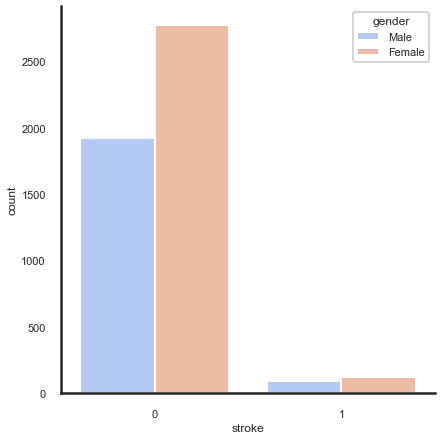

In [28]:
fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(3, 4)
sns.set_style("white")
sns.set_context("poster", font_scale=0.5)

ax_gender_stroke = fig.add_subplot(gs[:2, 2:4])
sns.countplot(x='stroke', hue='gender', data=clean_df_def_pd, ax=ax_gender_stroke, palette='coolwarm')
sns.despine()

##### Vediamo che in generale l'ictus colpisce poco più le donne che gli uomini

### Età e Stroke

#### Faccio un grafico per vedere il rapporto tra l'età e la variabile target

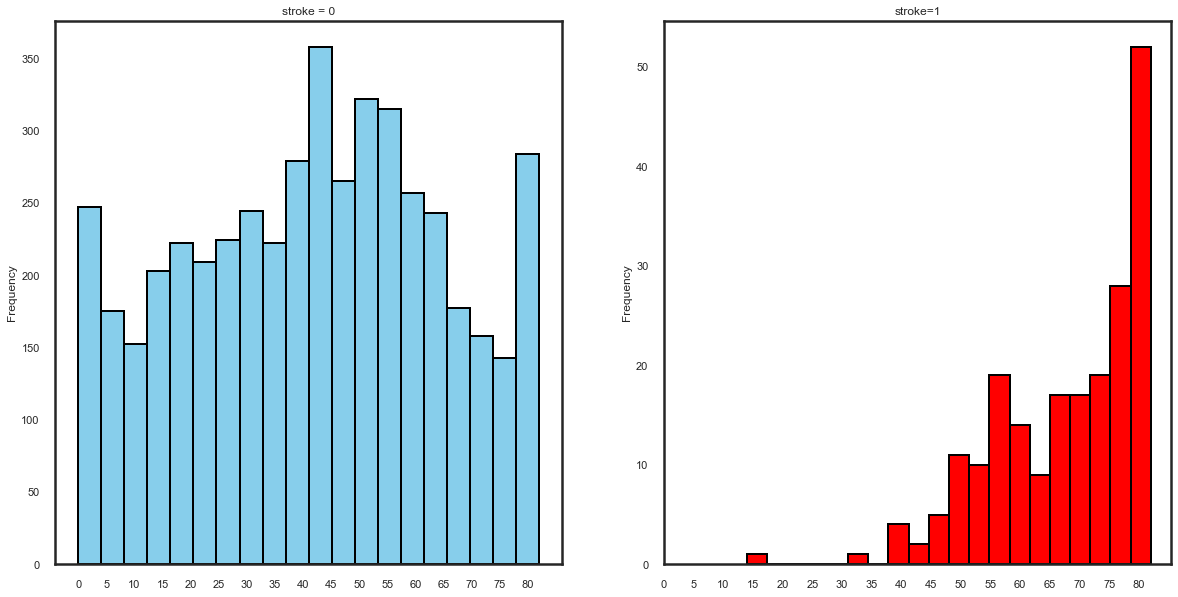

In [29]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

clean_df_def_pd.loc[clean_df_def_pd['stroke'] == 0]['age'].plot.hist(ax=ax[0], bins=20, edgecolor='black',
                                                                     color='skyblue')
ax[0].set_title('stroke = 0')
ax1 = list(range(0, 85, 5))
ax[0].set_xticks(ax1)

clean_df_def_pd[clean_df_def_pd['stroke'] == 1]['age'].plot.hist(ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('stroke=1')
x2 = list(range(0, 85, 5))
ax[1].set_xticks(x2)
plt.show();

##### Si può notare come all'avanzare dell'età, sia più probabile che si venga colpiti da un ictus

#### La variabile Age la trasformo in un range di età

In [30]:
clean_df_new = clean_df_new.withColumn('age_step',
                                       when(clean_df_new['age'] <= 30, 'young')
                                       .when((clean_df_new['age'] > 30) & (clean_df_new['age'] <= 55), 'adult')
                                       .otherwise('old')).drop('age')

In [31]:
clean_df_new.select(clean_df_new.age_step).show(5)

+--------+
|age_step|
+--------+
|     old|
|     old|
|   adult|
|     old|
|     old|
+--------+
only showing top 5 rows



### Hypertension e Stroke

#### Metto a grafico la relazione tra Hypertension e Stroke

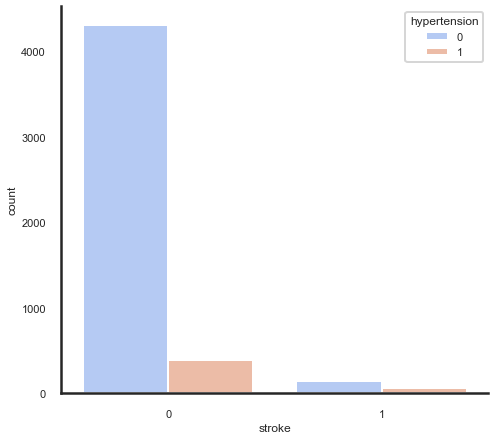

In [32]:
fig = plt.figure(figsize=(16, 11))
gs = fig.add_gridspec(3, 4)
sns.set_style("white")
sns.set_context("poster", font_scale=0.5)

ax_gender_stroke = fig.add_subplot(gs[:2, 2:4])
sns.countplot(x='stroke', hue='hypertension', data=clean_df_def_pd, ax=ax_gender_stroke, palette='coolwarm')
sns.despine()

##### L'ipertensione non sembra essere così influente nella determinazione di un ictus

### Heart Disease e Stroke

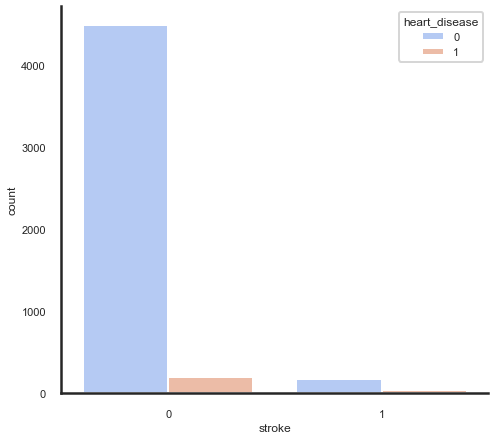

In [33]:
fig = plt.figure(figsize=(16, 11))
gs = fig.add_gridspec(3, 4)
sns.set_style("white")
sns.set_context("poster", font_scale=0.5)

ax_gender_stroke = fig.add_subplot(gs[:2, 2:4])
sns.countplot(x='stroke', hue='heart_disease', data=clean_df_def_pd, ax=ax_gender_stroke, palette='coolwarm')
sns.despine()

##### Anche i problemi cardiaci sembrano interessare poco l'avvento di un ictus

### Average glucose level e Stroke

#### Faccio prima una piccola panormamica per vedere la distribuzione della variabile 'Average_glucose_level'

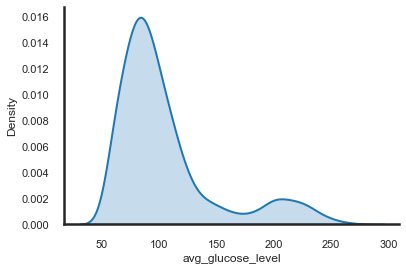

In [34]:
sns.kdeplot('avg_glucose_level', data=clean_df_def_pd, shade=True)
sns.set_style("white")
sns.despine()

##### Vediamo che la media del livello di glucosio nel sangue è sui 90

#### Successivamente la rapporto alla variabile target stroke

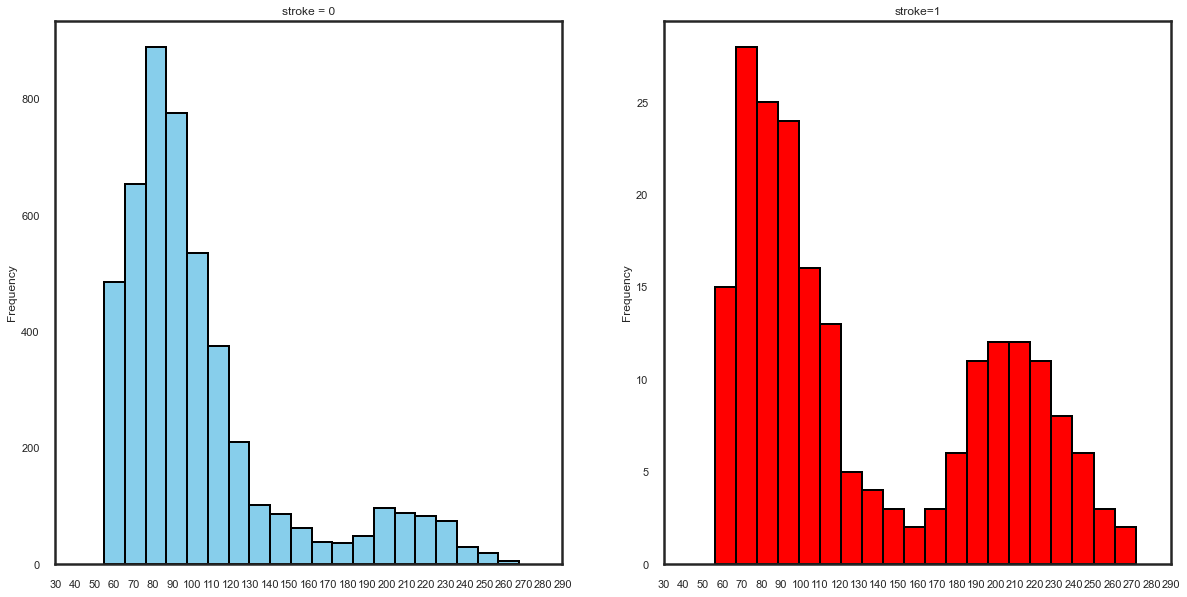

In [35]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

clean_df_def_pd.loc[clean_df_def_pd['stroke'] == 0]['avg_glucose_level'].plot.hist(ax=ax[0], bins=20, edgecolor='black',
                                                                                   color='skyblue')
ax[0].set_title('stroke = 0')
ax1 = list(range(30, 300, 10))
ax[0].set_xticks(ax1)

clean_df_def_pd.loc[clean_df_def_pd['stroke'] == 1]['avg_glucose_level'].plot.hist(ax=ax[1], color='red', bins=20,
                                                                                   edgecolor='black')
ax[1].set_title('stroke=1')
x2 = list(range(30, 300, 10))
ax[1].set_xticks(x2)
plt.show()

##### Dal grafico possiamo notare come aumentando il livello di glucosio aumenta anche la probabilità che possa arrivare l'ictus.

### BMI e Stroke

#### Piccola panoramica della variabile BMI da sola

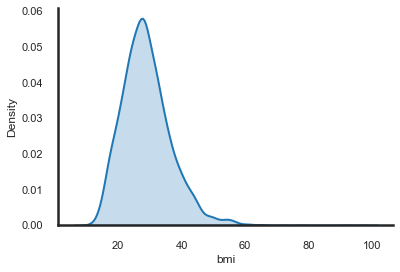

In [36]:
sns.kdeplot('bmi', data=clean_df_def_pd, shade=True)
sns.set_style("white")
sns.despine()

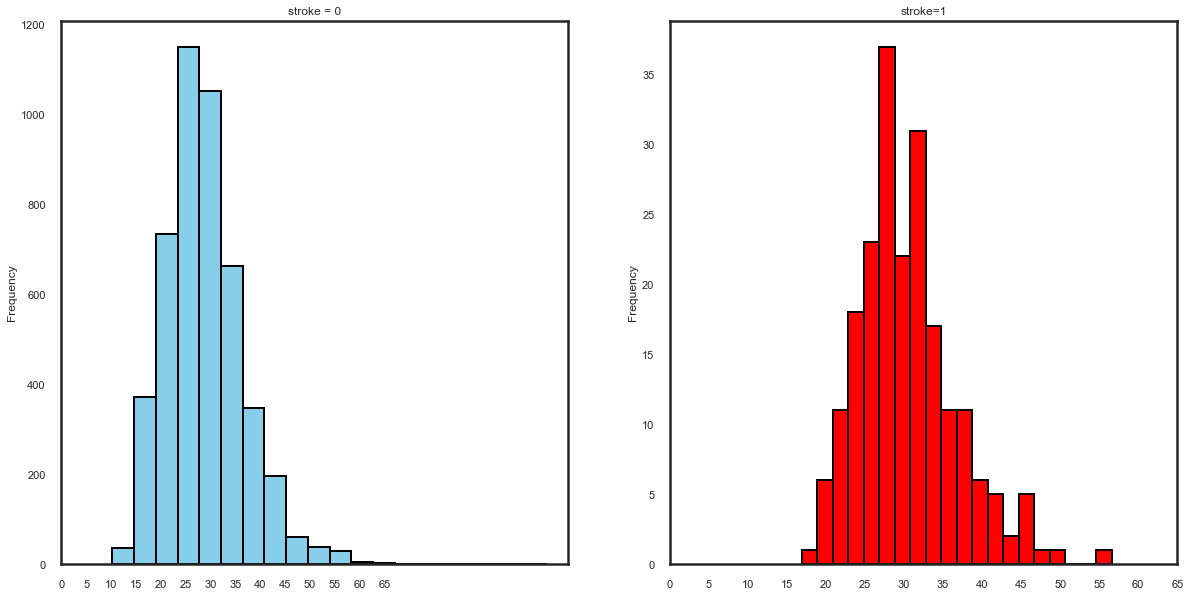

In [37]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

clean_df_def_pd.loc[clean_df_def_pd['stroke'] == 0]['bmi'].plot.hist(ax=ax[0], bins=20, edgecolor='black',
                                                                     color='skyblue')
ax[0].set_title('stroke = 0')
ax1 = list(range(0, 70, 5))
ax[0].set_xticks(ax1)

clean_df_def_pd.loc[clean_df_def_pd['stroke'] == 1]['bmi'].plot.hist(ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('stroke=1')
x2 = list(range(0, 70, 5))
ax[1].set_xticks(x2)
plt.show()

##### Notiamo che nel caso di ictus il bmi, ossia la condizione fisica, è più alto. Più alto è il bmi, più la persona si trova in uno stato di sovrappeso.

#### Voglio trasformare la variabile bmi in una variabile ordinale (fonte: https://www.my-personaltrainer.it/calcolo-bmi.html):

In [38]:
clean_df_new = clean_df_new.withColumn('bmi_ord',
                                       when(clean_df_new['bmi'] <= 16.5, 'severe_under_weight')
                                       .when((clean_df_new['bmi'] > 16.6) & (clean_df_new['bmi'] <= 18.4),
                                             'under_weight')
                                       .when((clean_df_new['bmi'] > 18.5) & (clean_df_new['bmi'] <= 24.9), 'normal')
                                       .when((clean_df_new['bmi'] > 25.0) & (clean_df_new['bmi'] <= 30.0), 'overweight')
                                       .when((clean_df_new['bmi'] > 30.1) & (clean_df_new['bmi'] <= 34.9), 'FG_obesity')
                                       .when((clean_df_new['bmi'] > 35.0) & (clean_df_new['bmi'] <= 40.0), 'SG_obesity')
                                       .otherwise('TG_obesity')).drop('bmi')

### Smoking_Status e Stroke

#### Metto a grafico anche la relazione tra la variabile 'smoking_status' e la target

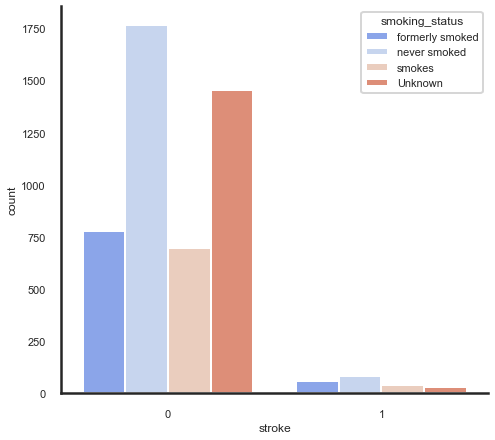

In [39]:
fig = plt.figure(figsize=(16, 11))
gs = fig.add_gridspec(3, 4)
sns.set_style("white")
sns.set_context("poster", font_scale=0.5)

ax_smoking_stroke = fig.add_subplot(gs[:2, 2:4])
sns.countplot(x='stroke', hue='smoking_status', data=clean_df_def_pd, ax=ax_smoking_stroke, palette='coolwarm')
sns.despine()

####

## Indexing, Encoding and VectorAssembly

#### Do uno sguardo al tipo di variabili che ho nel mio dataset in modo da capire come andare a codificarle

In [40]:
clean_df_new.printSchema()

root
 |-- gender: string (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- age_step: string (nullable = false)
 |-- bmi_ord: string (nullable = false)



#### Definisco inizialmente quali sono le mie variabili categoriche nominali e ordinali

In [41]:
NomCols = ['ever_married',
           'gender',
           'work_type',
           'Residence_type',
           'smoking_status',
            'age_step',
            'bmi_ord']

In [42]:
OrdCols = ['age_step', 'bmi_ord']

#### E successivamente vado ad indicizzarle attraverso una list comprehension, ciclando attraverso la lista precedentemente definita

In [43]:
one_indexer = [StringIndexer(inputCol=col, outputCol='index_' + col) for col in NomCols]


In [44]:
indexer = [StringIndexer(inputCol=col, outputCol='ord_' + col) for col in OrdCols]

#### Successivamente, sempre attraverso l'iterazione nella lista, vado a vettorizzare le variabili nominali precedentemente indicizzate

In [45]:
assembler = [VectorAssembler(inputCols=['index_' + col], outputCol="OHE_" + col) for col in NomCols]

#### E poi vado a decodificarle attraverso il OneHotEncoding

In [46]:
one_encoder = [OneHotEncoder(inputCol='index_' + col, outputCol='ind_vect_' + col) for col in NomCols]

#### Infine vado ad utilizzare una Pipeline che mi permette di poter collegare i vari step

In [47]:
pipeline = Pipeline(stages=one_indexer + assembler + indexer + one_encoder)

#### Vado poi ad adattarci il dataset e lo mando a schermo attraverso Pandas in modo da poter vedere le modifiche

In [48]:
final_dataframe = pipeline.fit(clean_df_new).transform(clean_df_new)

#### Utilizzo un ultimo assembler che prende in ingresso tutte le variabili decodificate e le trasforma in un'unica variabile 'features', che fungerà da X nella definizione dei modelli che utilizzeremo per andare a predire la Y

In [50]:
final_assembler = VectorAssembler(inputCols=['OHE_ever_married',
                                             'OHE_gender',
                                             'OHE_work_type',
                                             'OHE_Residence_type',
                                             'OHE_smoking_status',
                                             'ind_vect_age_step',
                                             'ind_vect_bmi_ord'],
                                  outputCol="features")
final_dataframe = final_assembler.transform(final_dataframe)

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,age_step,...,ord_age_step,ord_bmi_ord,ind_vect_ever_married,ind_vect_gender,ind_vect_work_type,ind_vect_Residence_type,ind_vect_smoking_status,ind_vect_age_step,ind_vect_bmi_ord,features
0,Male,0,1,Yes,Private,Urban,228.69,formerly smoked,1,old,...,1.0,3.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, ..."
1,Male,0,1,Yes,Private,Rural,105.92,never smoked,1,old,...,1.0,2.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,Female,0,0,Yes,Private,Urban,171.23,smokes,1,adult,...,0.0,2.0,(1.0),(1.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),"(0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, ..."
3,Female,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,old,...,1.0,1.0,(1.0),(1.0),"(0.0, 1.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
4,Male,0,0,Yes,Private,Urban,186.21,formerly smoked,1,old,...,1.0,0.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),"(0.0, 0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,Female,0,0,No,children,Rural,103.08,Unknown,0,young,...,2.0,1.0,(0.0),(1.0),"(0.0, 0.0, 1.0, 0.0)",(0.0),"(0.0, 1.0, 0.0)","(0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
4904,Female,0,0,Yes,Self-employed,Urban,125.20,never smoked,0,old,...,1.0,3.0,(1.0),(1.0),"(0.0, 1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4905,Female,0,0,Yes,Self-employed,Rural,82.99,never smoked,0,adult,...,0.0,2.0,(1.0),(1.0),"(0.0, 1.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4906,Male,0,0,Yes,Private,Rural,166.29,formerly smoked,0,adult,...,0.0,0.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(0.0),"(0.0, 0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, ..."


#### Definiamo un dataset con la Y e la X

In [51]:
model_data = final_dataframe.select("stroke", "features")

,stroke,features
0,1,"(0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, ..."
1,1,"(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,1,"(0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, ..."
3,1,"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
4,1,"(0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, ..."
...,...,...
4903,0,"(1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
4904,0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4905,0,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4906,0,"(0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, ..."


## MODELLI

#### Andiamo a dividere il dataset in training set e test set

In [66]:
training_set, test_set = model_data.randomSplit(weights=[0.6, 0.4], seed=7)

## Regressione Logistica

#### Utilizzo come primo modello una regressione logistica, andando ad utilizzare come predittore le features precedentemente definite e come variabile di risposta 'strokes'.

In [55]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'stroke', maxIter=10)

#### Addestro il modello su training set

In [56]:
lrModel = lr.fit(training_set)

#### Faccio un sommario del modello per poi mettere a grafico la curva ROC

In [57]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas() #lo converto a Pandas per fare il grafico

C:\Users\Michael\Desktop\Spark\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


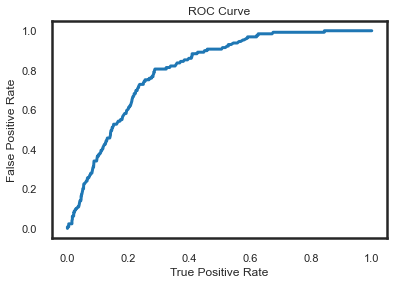

In [58]:
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### La curva ROC rappresenta il rapporto tra i Veri positivi e i Falsi Positivi. Dunque l'area sotto la curva, anche definita AUC, ci indica quanto è accurato il test

In [59]:
print('Training set AUC: ' + str(trainingSummary.areaUnderROC))

Training set AUC: 0.8034580718048268


#### Successivamente andiamo a fare predizione sul test set

In [60]:
predictions_lr = lrModel.transform(test_set)
predictions_lr.show(5)

+------+--------------------+--------------------+--------------------+----------+
|stroke|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|(13,[0,1,2,3,4],[...|[7.18617734210201...|[0.99924359531924...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[7.18617734210201...|[0.99924359531924...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[7.18617734210201...|[0.99924359531924...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[7.18617734210201...|[0.99924359531924...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[7.18617734210201...|[0.99924359531924...|       0.0|
+------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### E infine andiamo a valutare le prestazioni del modello:

In [61]:
evaluator = BinaryClassificationEvaluator(labelCol='stroke')
print('Test set AUC', evaluator.evaluate(predictions_lr))

Test set AUC 0.8007745726495723


## Random Forest

#### Definiamo inizialmente il modello:

In [62]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'stroke', numTrees=150)

#### Lo addestriamo nel training set:

In [63]:
rfModel = rf.fit(training_set)

#### E andiamo a fare predizione attraverso il test set:

In [64]:
predictions_rf = rfModel.transform(test_set)
predictions_rf.show()

+------+--------------------+--------------------+--------------------+----------+
|stroke|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|     0|(13,[0,1,2,3,4],[...|[145.498868129839...|[0.96999245419893...|       0.0|
|   


#### Infine andiamo a valutare le prestazioni del modello:

In [65]:
evaluator = BinaryClassificationEvaluator(labelCol="stroke")
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy = %s" % accuracy)
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.7939102564102564
Test Error = 0.20608974358974363
